In [1]:
from matplotlib import pyplot as plt
from analysis_util import fit_mlb_polynomial,ConstrainedPolynomial
import numpy as np
import pandas as pd
import pathlib
from scipy.spatial.distance import cdist
from numpy.polynomial import Polynomial

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times'],'weight': 'bold'})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])
from matplotlib.ticker import AutoMinorLocator

### Prepare Nogami Data

In [2]:
temperatures = np.concatenate([[23],np.linspace(100,1100,11)])
data = []
for file in pathlib.WindowsPath('raw/nogami_data').iterdir():
    df = pd.read_csv(file,header = None,index_col= 0)
    td = cdist(df.index.to_numpy()[:,np.newaxis],temperatures[:,np.newaxis])
    index = td.argmin(axis = 1)
    df.index = temperatures[index]
    df.columns = [file.name.split('.')[0]]
    data.append(df.copy())

nogami_df = pd.concat(data,axis = 1)
nogami_df.index += 273.15
nogami_df.index.name = 'Temperature [K]'
nogami_df.to_csv('nogami_data.csv')



### Prepare Roedig Data

In [3]:
temperatures = np.concatenate([[23,50],np.linspace(100,1600,16)])
temperatures = temperatures.astype(int)
data = []
for file in pathlib.WindowsPath('raw/roedig_data').iterdir():
    df = pd.read_csv(file,header = None,index_col= 0)
    td = cdist(df.index.to_numpy()[:,np.newaxis],temperatures[:,np.newaxis])
    index = td.argmin(axis = 1)
    df.reindex(temperatures[index])
    df.columns = ['.'.join(file.name.split('.')[:-1])]
    data.append(df.copy())

roedig_df = pd.concat(data,axis = 1)
roedig_df.index += 273.15
roedig_df.index.name = 'Temperature [K]'
roedig_df.to_csv('roedig_data.csv')

print(roedig_df.columns)


Index(['Pure W', 'Pure W Irradiated 1 dpa', 'WL10', 'WL10 Irradiated 0.6 dpa'], dtype='object')


### ITER MPH Data

In [4]:
iterw_poly = Polynomial(np.array([174.9274,-0.1067,5.0067e-5,-7.8349e-9]))
iterwl10_poly = Polynomial(np.array([124.3,-0.04148,1.443e-5]))
xplot_iter = np.linspace(20,3500,1000)
corrected = Polynomial.fit(xplot_iter + 273.15,iterw_poly(xplot_iter),3)
print(corrected.convert().coef)

[ 2.07967725e+02 -1.35805309e-01  5.64873088e-05 -7.83490000e-09]


### MT185
from Bailey's thesis

In [5]:
mt185_df = pd.read_csv('mt185.csv',index_col = 0)

### Plot Agglomerated Data

c:\Users\mlanahan3\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


[ 1.93231046e+02 -9.79929100e-02  3.64619057e-05 -5.95590440e-09
  3.14455143e-13]


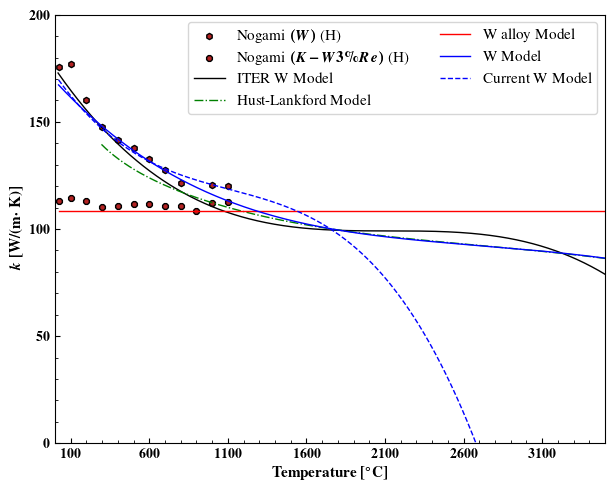

In [47]:

MARKER_SIZE = 20
ALPHA = 1.0


def build_hacky_poly(name: str):
    
    x,y = nogami_df.index.to_numpy(),nogami_df[name].to_numpy()
    index = np.all(
        np.concatenate([~np.isnan(y)[:,np.newaxis],
                            x[:,np.newaxis] <= 1200,
                            x[:,np.newaxis] >= 300],axis = 1),
                            axis = 1)

    xlims = [[300,1200],[1200,5000]]
    weights = [1,1]
    x,y = x[index],y[index]
    poly1 = Polynomial(np.array([206.9986,-0.1524686,9.578013e-05,-2.299503e-08]))
    poly3 = lambda x: hl_model(x)

    xx = []
    yy = []
    for xlim,poly,w in zip(xlims,[poly1,poly3],weights):
        x = np.linspace(*xlim,100*w)
        xx.append(x)
        yy.append(poly(x))
    
    x = np.concatenate(xx)
    y = np.concatenate(yy)
    poly = Polynomial.fit(x,y,4)
    return poly

current_w_poly = Polynomial(np.array([206.9986,-0.1524686,9.578013e-05,-2.299503e-08]))
def fit_conductivity_poly(name: str,*args,**kwargs):
    x,y = nogami_df.index.to_numpy(),nogami_df[name].to_numpy()
    index = np.all(
        np.concatenate([~np.isnan(y)[:,np.newaxis],
                            x[:,np.newaxis] <= 1200,
                            x[:,np.newaxis] >= 300],axis = 1),
                            axis = 1)

    x,y = x[index],y[index]
    poly = fit_mlb_polynomial(x,y,*args,**kwargs)
    return poly

def fit_constrained_poly(name: str,*args,**kwargs):

    x,y = nogami_df.index.to_numpy(),nogami_df[name].to_numpy()
    index = np.all(
        np.concatenate([~np.isnan(y)[:,np.newaxis],
                            x[:,np.newaxis] >= 300],axis = 1),
                            axis = 1)

    x,y = x[index],y[index]
    poly = ConstrainedPolynomial.fit(x.squeeze(),y.squeeze(),*args,**kwargs)
    return poly

def hl_model(x: np.ndarray) -> np.ndarray:
    poly_hl = Polynomial([149.441,-45.466e-3,13.193e-6,-1.484e-9])
    return poly_hl(x) + 3.866e6/x**2

poly = fit_conductivity_poly('K-doped W-3%Re (H) Plate',1,end_constraints = [2])
poly_w = build_hacky_poly('Pure W (H) Plate')



fig,ax = plt.subplots(figsize = (6.25,5.))
"""
nogami_label_map = {'Pure W (H) Plate': 'Nogami $(W)$ (H)',
                     'W-3%Re (H) Plate': r'Nogami  $(W3\%Re)$ (H)',
                     'W-1%Re (H) Plate': r'Nogami $(W3\%Re-1\%La_2O_3)$  (L)',
                     'K-doped W-3%Re (H) Plate': r'Nogami $(K-W3\%Re)$ (H)'}
"""
nogami_label_map = {'Pure W (H) Plate': 'Nogami $(W)$ (H)',
                     'K-doped W-3%Re (H) Plate': r'Nogami $(K-W3\%Re)$ (H)'}

nogami_marker_map = {'Pure W (H) Plate': 'h',
                     'W-3%Re (H) Plate': 'v',
                     'W-1%Re (H) Plate': '^',
                     'K-doped W-3%Re (H) Plate': '8'}

for col in nogami_label_map:
    ax.scatter(nogami_df.index - 273.15,nogami_df[col].to_numpy(),s =MARKER_SIZE if col != 'K-doped W-3%Re (H) Plate' else MARKER_SIZE,
               marker = nogami_marker_map[col],edgecolor = 'k',facecolor = 'firebrick',alpha = ALPHA if col != 'K-doped W-3%Re (H) Plate' else 1,
               label = nogami_label_map[col])

roedig_label_map = {'Pure W': 'Roedig $(W)$', 
                     'Pure W Irradiated 1 dpa': 'Roedig $(W)$ 1 dpa', 
                     'WL10': 'Roedig $(WL10)$', 
                     'WL10 Irradiated 0.6 dpa': 'Roedig $(W)$ 0.6 dpa'}

roedig_marker_map = {'Pure W': 'h', 
                     'Pure W Irradiated 1 dpa': 'X', 
                     'WL10': '^', 
                     'WL10 Irradiated 0.6 dpa': 'p'}


"""
for col in roedig_label_map:
    ax.scatter(roedig_df.index - 273.15,roedig_df[col].to_numpy(),s =MARKER_SIZE,
               marker = roedig_marker_map[col],edgecolor = 'k',facecolor = 'blue',
               label = roedig_label_map[col],alpha = ALPHA)
"""

#ax.scatter(mt185_df.index,mt185_df.to_numpy(),s = MARKER_SIZE,edgecolor = 'k',facecolor = 'lime',label = 'MT185',alpha = ALPHA)


xplot = np.linspace(nogami_df.index.min(),4500,1000)
ax.plot(xplot_iter,iterw_poly(xplot_iter),linewidth = 1,color = 'k',label = 'ITER W Model')
ax.plot(xplot,hl_model(xplot + 273.15),linewidth = 1,ls = '-.',color = 'green',label = 'Hust-Lankford Model')
#ax.plot(xplot_iter,iterwl10_poly(xplot_iter),linewidth = 1,color = 'k',linestyle = '--',label = 'ITER WL10')
ax.plot(xplot - 273.15,poly(xplot),linewidth = 1,color = 'red',label = 'W alloy Model')
ax.plot(xplot - 273.15,poly_w(xplot),linewidth = 1,color = 'blue',label = 'W Model')
ax.plot(xplot - 273.15,current_w_poly(xplot),linewidth = 1,color = 'blue',ls = '--',label = 'Current W Model')
ax.legend(fontsize = 11,ncols = 2)


xfit = np.linspace(300,5000)
yfit = poly_w(xfit)
print(poly_w.convert().coef)

ax.set_xlabel(r'\textbf{Temperature [}$^\circ$\textbf{C]}',fontsize = 11)
ax.set_ylabel(r'$k$ \textbf{[W/(m}$\cdot$\textbf{ K)]}',fontsize = 11)
ax.tick_params('both',labelsize = 10,direction = 'in',which = 'both')

ax.set_yticks(np.arange(0,250,50))
ax.set_xticks(np.arange(100,4200,500))

ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xlim([0,3500])
ax.set_ylim([0,200])
fig.tight_layout()
fig.savefig('conductivity_model_comparison.svg')
